In [1]:
import os
os.chdir('..')

import sys
from datetime import datetime
from dateutil.tz import tzlocal
import pytz
import re
import numpy as np
import pandas as pd

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior, utilities)
import pynwb
from pynwb import NWBFile, NWBHDF5IO

Connecting root@127.0.0.1:3306


In [15]:
ephys_erd = (dj.ERD(acquisition.Session) + (dj.ERD(intracellular.Cell) + 1) + (dj.ERD(extracellular.ProbeInsertion) + 1))

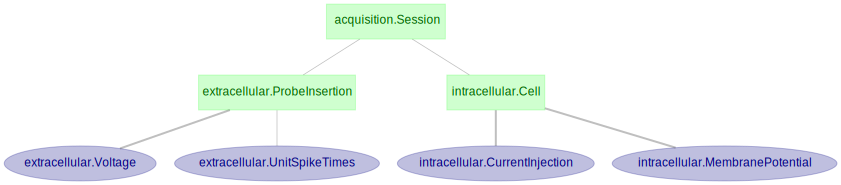

In [26]:
ephys_erd

In [21]:
behav_erd = (dj.ERD(acquisition.Session) + (dj.ERD(behavior.LickTrace)) + (dj.ERD(stimulation.PhotoStimulation)) + 
             (dj.ERD(acquisition.TrialSet)+1))

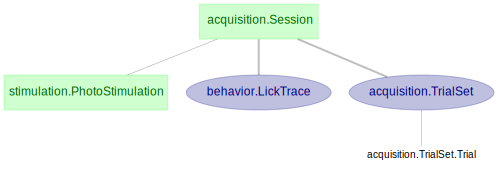

In [24]:
behav_erd

In [33]:
meta_erd = (dj.ERD(acquisition.Session) - 2)

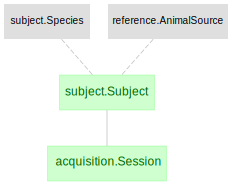

In [34]:
meta_erd

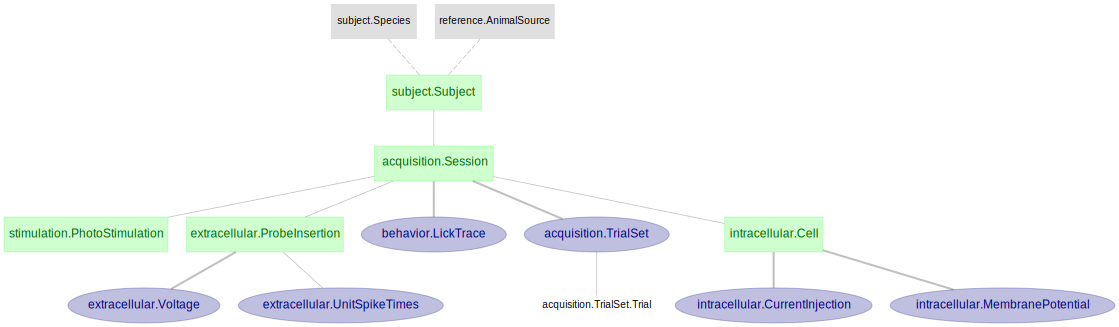

In [52]:
meta_erd + ephys_erd + behav_erd

In [53]:
(meta_erd + ephys_erd + behav_erd).save('images/simplified_erd.png')

## Working with one session

In [ ]:
session_keys = acquisition.Session.fetch('KEY')

In [83]:
session_key = session_keys[-5]

In [41]:
acquisition.Session & session_key

subject_id id of the subject (e.g. ANM244028),session_time session time,session_directory,session_note
anm00229327,2017-06-27 09:34:49,,"Extracellular ephys recording of mouse doing discrimination task(lick left/right), with optogenetic stimulation plus pole and auditory stimulus"


In [50]:
this_session = (acquisition.Session & session_key).fetch1()

### The meta information

In [44]:
    # =============== General ====================
    # -- NWB file - a NWB2.0 file for each session
    nwbfile = NWBFile(
        session_description=this_session['session_note'],
        identifier='_'.join(
            [this_session['subject_id'],
             this_session['session_time'].strftime('%Y-%m-%d_%H-%M-%S')]),
        session_start_time=this_session['session_time'],
        file_create_date=datetime.now(tzlocal()),
        experimenter='; '.join((acquisition.Session.Experimenter
                                & session_key).fetch('experimenter')),
        institution='Janelia Research Campus', 
        related_publications='doi:10.1038/nature22324') 
    # -- subject
    subj = (subject.Subject & session_key).fetch1()
    nwbfile.subject = pynwb.file.Subject(
        subject_id=this_session['subject_id'],
        description=subj['subject_description'],
        genotype=' x '.join((subject.Subject.Allele 
                             & session_key).fetch('allele')),
        sex=subj['sex'],
        species=subj['species'])

C:\ProgramData\Anaconda3\lib\site-packages\pynwb\file.py:615: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


In [45]:
nwbfile


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { }
  analysis: { }
  devices: { }
  electrode_groups: { }
  epoch_tags: {}
  experimenter: Zengcai Guo
  ic_electrodes: { }
  imaging_planes: { }
  institution: Janelia Research Campus
  lab_meta_data: { }
  modules: { }
  ogen_sites: { }
  related_publications: doi:10.1038/nature22324
  stimulus: { }
  stimulus_template: { }
  subject: subject <class 'pynwb.file.Subject'>
  time_intervals: { }

In [46]:
nwbfile.subject


subject <class 'pynwb.file.Subject'>
Fields:
  genotype: Ai35D x GAD2_Cre
  sex: M
  species: Mus musculus
  subject_id: anm00229327

In [47]:
acquisition.Session * subject.Subject & session_key

subject_id id of the subject (e.g. ANM244028),session_time session time,session_directory,session_note,species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm00229327,2017-06-27 09:34:49,,"Extracellular ephys recording of mouse doing discrimination task(lick left/right), with optogenetic stimulation plus pole and auditory stimulus",Mus musculus,Jackson,M,None,None


## Intracellular

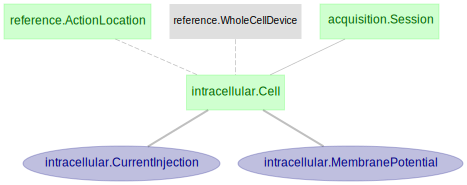

In [60]:
(dj.ERD(acquisition.Session) + (dj.ERD(intracellular.Cell) + 1)
+ dj.ERD(reference.WholeCellDevice) + dj.ERD(reference.ActionLocation))

In [59]:
cell = (intracellular.Cell & session_key).fetch1()

OrderedDict([('subject_id', 'anm324792'),
             ('session_time', datetime.datetime(2017, 5, 20, 19, 35, 55)),
             ('cell_id', 'cell_65_1'),
             ('cell_type', 'N/A'),
             ('brain_region', 'ALM'),
             ('brain_subregion', 'N/A'),
             ('cortical_layer', 'N/A'),
             ('hemisphere', 'left'),
             ('coordinate_ref', 'bregma'),
             ('coordinate_ap', Decimal('2.50')),
             ('coordinate_ml', Decimal('1.50')),
             ('coordinate_dv', Decimal('0.43')),
             ('device_name', 'Multiclamp_700B')])

In [61]:
# metadata
whole_cell_device = nwbfile.create_device(name=cell['device_name'])
ic_electrode = nwbfile.create_ic_electrode(
    name=cell['cell_id'],
    device=whole_cell_device,
    description='N/A',
    filtering='low-pass: 10kHz', 
    location='; '.join([f'{k}: {str(v)}'
                        for k, v in (reference.ActionLocation & cell).fetch1().items()]))
# acquisition - membrane potential
mp, mp_wo_spike, mp_start_time, mp_fs = (intracellular.MembranePotential & cell).fetch1(
    'membrane_potential', 'membrane_potential_wo_spike',
    'membrane_potential_start_time', 'membrane_potential_sampling_rate')
nwbfile.add_acquisition(pynwb.icephys.PatchClampSeries(name='membrane_potential',
                                                       electrode=ic_electrode,
                                                       unit='mV', 
                                                       conversion=1e-3,
                                                       gain=1.0, 
                                                       data=mp,
                                                       starting_time=mp_start_time,
                                                       rate=mp_fs))
# acquisition - current injection
current_injection, ci_start_time, ci_fs = (intracellular.CurrentInjection & cell).fetch1(
    'current_injection', 'current_injection_start_time', 'current_injection_sampling_rate')
nwbfile.add_stimulus(pynwb.icephys.CurrentClampStimulusSeries(name='current_injection',
                                                              electrode=ic_electrode,
                                                              unit='nA',
                                                              conversion=1e-6,
                                                              gain=1.0,
                                                              data=current_injection,
                                                              starting_time=ci_start_time,
                                                              rate=ci_fs))

In [62]:
nwbfile


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { membrane_potential <class 'pynwb.icephys.PatchClampSeries'> }
  analysis: { }
  devices: { Multiclamp_700B <class 'pynwb.device.Device'> }
  electrode_groups: { }
  epoch_tags: {}
  experimenter: Zengcai Guo
  ic_electrodes: { cell_65_1 <class 'pynwb.icephys.IntracellularElectrode'> }
  imaging_planes: { }
  institution: Janelia Research Campus
  lab_meta_data: { }
  modules: { }
  ogen_sites: { }
  related_publications: doi:10.1038/nature22324
  stimulus: { current_injection <class 'pynwb.icephys.CurrentClampStimulusSeries'> }
  stimulus_template: { }
  subject: subject <class 'pynwb.file.Subject'>
  time_intervals: { }

## Extracellular

In [66]:
probe_insertion = (extracellular.ProbeInsertion & session_key).fetch1()

In [67]:
probe_insertion

OrderedDict([('subject_id', 'anm00229329'),
             ('session_time', datetime.datetime(2017, 6, 27, 9, 34, 56)),
             ('probe_name', 'ADunit'),
             ('channel_counts', 32),
             ('brain_region', 'Thalamus'),
             ('brain_subregion', 'N/A'),
             ('cortical_layer', 'N/A'),
             ('hemisphere', 'left'),
             ('coordinate_ref', 'bregma'),
             ('coordinate_ap', Decimal('2.50')),
             ('coordinate_ml', Decimal('-1.50')),
             ('coordinate_dv', Decimal('0.00'))])

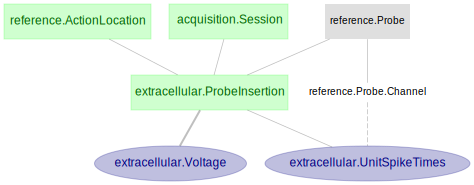

In [74]:
(dj.ERD(acquisition.Session) + (dj.ERD(extracellular.ProbeInsertion) -1) + (dj.ERD(extracellular.ProbeInsertion) +1)) 

In [77]:
# =============== Extracellular ====================
probe_insertion = ((extracellular.ProbeInsertion & session_key).fetch1()
                   if extracellular.ProbeInsertion & session_key
                   else None)
if probe_insertion:
    probe = nwbfile.create_device(name = probe_insertion['probe_name'])
    electrode_group = nwbfile.create_electrode_group(
        name='; '.join([f'{probe_insertion["probe_name"]}: {str(probe_insertion["channel_counts"])}']),
        description = 'N/A',
        device = probe,
        location = '; '.join([f'{k}: {str(v)}' for k, v in
                              (reference.ActionLocation & probe_insertion).fetch1().items()]))

    for chn in (reference.Probe.Channel & probe_insertion).fetch(as_dict=True):
        nwbfile.add_electrode(id=chn['channel_id'],
                              group=electrode_group,
                              filtering='Bandpass filtered 300-6K Hz',
                              imp=-1.,
                              x=chn['channel_x_pos'],
                              y=chn['channel_y_pos'],
                              z=chn['channel_z_pos'],
                              location=electrode_group.location)

    # --- unit spike times ---
    nwbfile.add_unit_column(name='unit_x', description='x-coordinate of this unit')
    nwbfile.add_unit_column(name='unit_y', description='y-coordinate of this unit')
    nwbfile.add_unit_column(name='unit_z', description='z-coordinate of this unit')
    nwbfile.add_unit_column(name='unit_cell_type', description='cell type (e.g. wide width, narrow width spiking)')

    for unit in (extracellular.UnitSpikeTimes & probe_insertion).fetch(as_dict=True):
        # make an electrode table region (which electrode(s) is this unit coming from)
        nwbfile.add_unit(id=unit['unit_id'],
                         electrodes=(unit['channel_id']
                                     if isinstance(unit['channel_id'], np.ndarray) else [unit['channel_id']]),
                         unit_x=unit['unit_x'],
                         unit_y=unit['unit_y'],
                         unit_z=unit['unit_z'],
                         unit_cell_type=unit['unit_cell_type'],
                         spike_times=unit['spike_times'],
                         waveform_mean=np.mean(unit['spike_waveform'], axis=0),
                         waveform_sd=np.std(unit['spike_waveform'], axis=0))


## Behavior

In [85]:
# =============== Behavior ====================
behavior_data = ((behavior.LickTrace & session_key).fetch1()
                 if behavior.LickTrace & session_key
                 else None)
if behavior_data:
    behav_acq = pynwb.behavior.BehavioralTimeSeries(name = 'lick_trace')
    nwbfile.add_acquisition(behav_acq)
    [behavior_data.pop(k) for k in behavior.LickTrace.primary_key]
    lt_start_time = behavior_data.pop('lick_trace_start_time')
    lt_fs = behavior_data.pop('lick_trace_sampling_rate')
    for b_k, b_v in behavior_data.items():
        behav_acq.create_timeseries(name = b_k,
                                    unit = 'a.u.',
                                    conversion = 1.0,
                                    data = b_v,
                                    starting_time=lt_start_time,
                                    rate=lt_fs)

## Photostim

In [88]:
# =============== Photostimulation ====================
photostim = ((stimulation.PhotoStimulation & session_key).fetch1()
                   if stimulation.PhotoStimulation & session_key
                   else None)
if photostim:
    photostim_device = (stimulation.PhotoStimDevice & photostim).fetch1()
    stim_device = nwbfile.create_device(name=photostim_device['device_name'])
    stim_site = pynwb.ogen.OptogeneticStimulusSite(
        name='-'.join([photostim['hemisphere'], photostim['brain_region']]),
        device=stim_device,
        excitation_lambda=float(photostim['photo_stim_excitation_lambda']),
        location = '; '.join([f'{k}: {str(v)}' for k, v in
                              (reference.ActionLocation & photostim).fetch1().items()]),
        description=(stimulation.PhotoStimulationInfo & photostim).fetch1('photo_stim_notes'))
    nwbfile.add_ogen_site(stim_site)

    if photostim['photostim_timeseries'] is not None:
        nwbfile.add_stimulus(pynwb.ogen.OptogeneticSeries(
            name='_'.join(['photostim_on', photostim['photostim_datetime'].strftime('%Y-%m-%d_%H-%M-%S')]),
            site=stim_site,
            unit = 'mW',
            resolution = 0.0,
            conversion = 1e-6,
            data = photostim['photostim_timeseries'],
            starting_time = photostim['photostim_start_time'],
            rate = photostim['photostim_sampling_rate']))

## TrialSet

In [94]:
# =============== TrialSet ====================
# NWB 'trial' (of type dynamic table) by default comes with three mandatory attributes:
#                                                                       'id', 'start_time' and 'stop_time'.
# Other trial-related information needs to be added in to the trial-table as additional columns (with column name
# and column description)
if acquisition.TrialSet & session_key:
    # Get trial descriptors from TrialSet.Trial and TrialStimInfo
    trial_columns = [{'name': tag,
                      'description': re.sub('\s+:|\s+', ' ', re.search(
                          f'(?<={tag})(.*)', str((acquisition.TrialSet.Trial * stimulation.TrialPhotoStimInfo).heading)).group())}
                     for tag in (acquisition.TrialSet.Trial * stimulation.TrialPhotoStimInfo).fetch(as_dict=True, limit=1)[0].keys()
                     if tag not in (acquisition.TrialSet.Trial & stimulation.TrialPhotoStimInfo).primary_key + ['start_time', 'stop_time']]

    # Trial Events
    trial_events = set((acquisition.TrialSet.EventTime & session_key).fetch('trial_event'))
    event_names = [{'name': e, 'description': d}
                   for e, d in zip(*(reference.ExperimentalEvent & [{'event': k}
                                                                    for k in trial_events]).fetch('event',
                                                                                                  'description'))]
    # Add new table columns to nwb trial-table for trial-label
    for c in trial_columns + event_names:
        nwbfile.add_trial_column(**c)

    photostim_tag_default = {tag: '' for tag in stimulation.TrialPhotoStimInfo().fetch(as_dict=True, limit=1)[0].keys()
                             if tag not in stimulation.TrialPhotoStimInfo.primary_key}
    # Add entry to the trial-table
    for trial in (acquisition.TrialSet.Trial & session_key).fetch(as_dict=True):
        events = dict(zip(*(acquisition.TrialSet.EventTime & trial).fetch('trial_event', 'event_time')))

        photostim_tag = (stimulation.TrialPhotoStimInfo & trial).fetch(as_dict=True)
        trial_tag_value = {**trial, **events, **photostim_tag[0]} if len(photostim_tag) == 1 else {**trial, **events, **photostim_tag_default}
        # rename 'trial_id' to 'id'
        trial_tag_value['id'] = trial_tag_value['trial_id']
        [trial_tag_value.pop(k) for k in acquisition.TrialSet.Trial.primary_key]
        nwbfile.add_trial(**trial_tag_value)


In [103]:
nwbfile


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { lick_trace <class 'pynwb.behavior.BehavioralTimeSeries'>,  membrane_potential <class 'pynwb.icephys.PatchClampSeries'> }
  analysis: { }
  devices: { ADunit <class 'pynwb.device.Device'>,  Multiclamp_700B <class 'pynwb.device.Device'>,  laser <class 'pynwb.device.Device'> }
  electrode_groups: { ADunit: 32 <class 'pynwb.ecephys.ElectrodeGroup'> }
  electrodes: electrodes <class 'pynwb.core.DynamicTable'>
  epoch_tags: {}
  experimenter: Zengcai Guo
  ic_electrodes: { cell_65_1 <class 'pynwb.icephys.IntracellularElectrode'> }
  imaging_planes: { }
  institution: Janelia Research Campus
  lab_meta_data: { }
  modules: { }
  ogen_sites: { left-VM <class 'pynwb.ogen.OptogeneticStimulusSite'> }
  related_publications: doi:10.1038/nature22324
  stimulus: { current_injection <class 'pynwb.icephys.CurrentClampStimulusSeries'>,  photostim_on_2017-05-20_19-24-47 <class 'pynwb.ogen.OptogeneticSeries'> }
  stimulus_template: { }
  subject

## Write NWB 2.0 file

In [104]:
with NWBHDF5IO(os.path.join('data', 'nwb', 'data.nwb'), mode = 'w') as io:
    io.write(nwbfile)

In [105]:
with NWBHDF5IO(os.path.join('data', 'nwb', 'data.nwb'), mode = 'r') as io:
    nwbfile2 = io.read()

In [106]:
nwbfile2


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { lick_trace <class 'pynwb.behavior.BehavioralTimeSeries'>,  membrane_potential <class 'pynwb.icephys.PatchClampSeries'> }
  analysis: { }
  devices: { ADunit <class 'pynwb.device.Device'>,  Multiclamp_700B <class 'pynwb.device.Device'>,  laser <class 'pynwb.device.Device'> }
  electrode_groups: { ADunit: 32 <class 'pynwb.ecephys.ElectrodeGroup'> }
  electrodes: electrodes <class 'pynwb.core.DynamicTable'>
  epoch_tags: {}
  experimenter: Zengcai Guo
  ic_electrodes: { cell_65_1 <class 'pynwb.icephys.IntracellularElectrode'> }
  imaging_planes: { }
  institution: Janelia Research Campus
  lab_meta_data: { }
  modules: { }
  ogen_sites: { left-VM <class 'pynwb.ogen.OptogeneticStimulusSite'> }
  related_publications: doi:10.1038/nature22324
  stimulus: { current_injection <class 'pynwb.icephys.CurrentClampStimulusSeries'>,  photostim_on_2017-05-20_19-24-47 <class 'pynwb.ogen.OptogeneticSeries'> }
  stimulus_template: { }
  subject

In [75]:
extracellular.UnitSpikeTimes()

subject_id id of the subject (e.g. ANM244028),session_time session time,probe_name String naming probe model,channel_counts number of channels in the probe,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,coordinate_ref,"coordinate_ap in mm, anterior positive, posterior negative","coordinate_ml in mm, always postive, number larger when more lateral","coordinate_dv in mm, always postive, number larger when more ventral (deeper)",unit_id,channel_id id of a channel on the probe,"spike_times (s) time of each spike, with respect to the start of session","unit_cell_type e.g. cell-type of this unit (e.g. wide width, narrow width spiking)",unit_x (mm),unit_y (mm),unit_z (mm),spike_waveform waveform(s) of each spike at each spike time (spike_time x waveform_timestamps)
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,1,4,=BLOB=,Wide width spiking,1.25484,-4.1364,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,2,9,=BLOB=,Wide width spiking,1.37573,-4.47608,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,3,13,=BLOB=,Wide width spiking,1.47317,-4.08813,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,4,14,=BLOB=,Wide width spiking,1.49753,-3.99115,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,5,27,=BLOB=,Wide width spiking,1.8124,-4.37956,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,6,28,=BLOB=,Wide width spiking,1.83676,-4.28257,-1.57826,=BLOB=
anm00229327,2017-06-27 09:34:38,ADunit,32,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,7,28,=BLOB=,Wide width spiking,1.83676,-4.28257,-1.57826,=BLOB=


In [76]:
acquisition.TrialSet.Trial()

subject_id id of the subject (e.g. ANM244028),session_time session time,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,trial_is_good is this a good or bad trial
anm00229327,2017-06-27 09:34:38,1,2.36285,3117.27,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,2,3117.27,3126.26,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,3,3126.26,3135.9,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,4,3135.9,3144.07,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,5,3144.07,3152.95,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,6,3152.95,3160.72,non-performing,N/A,0,0
anm00229327,2017-06-27 09:34:38,7,3160.72,3168.56,non-performing,N/A,0,0


In [107]:
NWBFile.trials